In [1]:
import pandas as pd
import numpy as np
from script import *
import itertools
import lightgbm as lgbm
import matplotlib.pyplot as plt

import time

In [2]:
pd.set_option('display.max_rows',200)
idx = pd.IndexSlice
agg_operations =['mean','median','max','min','size']

In [4]:
start = 20130101
cursor = dbop.connect_db("sqlite3").cursor()

df_d = dbop.create_df(cursor, STOCK_DAY[TABLE], start=start)
df_d = dp.proc_stock_d(dp.prepare_stock_d(df_d))
df_d.drop(columns=['open0','high0','low0','vol0'],inplace=True)
df_d['pct'] = df_d.sort_index().groupby('code')['close'].pct_change()*100
print(df_d.columns)
print(df_d.shape)

select * from stock_day where date>=20130101
Index(['open', 'high', 'low', 'close', 'vol', 'amt', 'adj_factor', 'avg',
       'close0', 'avg0', 'pct'],
      dtype='object')
(2304627, 11)


In [12]:
# 确认数据已排序，保证shift操作无误。
print(df_d.index.is_lexsorted())
print(df_d.head())

df_d['open/prev_close'] = df_d['open']/df_d.groupby('code')['close'].shift(1)
df_d['close/open'] = df_d['close']/df_d['open']
print(df_d.head())

True
                           open       high        low      close  \
code      date                                                     
000001.SZ 2013-01-04  590.34336  595.04585  575.87416  578.40627   
          2013-01-07  578.04454  591.42855  574.42724  589.61990   
          2013-01-08  589.61990  592.15201  573.70378  578.76800   
          2013-01-09  577.32108  579.49146  571.53340  573.70378   
          2013-01-10  573.70378  582.38530  571.17167  574.06551   

                               vol          amt  adj_factor         avg  \
code      date                                                            
000001.SZ 2013-01-04  12270.239405  717567.5466      36.173  584.803216   
          2013-01-07   9873.918392  578450.4876      36.173  585.836812   
          2013-01-08   8638.462942  501360.0937      36.173  580.381136   
          2013-01-09   6947.976391  399696.1831      36.173  575.269921   
          2013-01-10   6635.619661  383347.7326      36.173  577.712

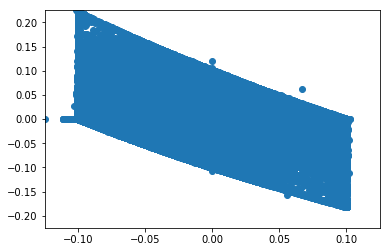

In [16]:
# 散点图无法有效展示信息，基本被涨跌停限死。
plt.scatter(df_d['open/prev_close']-1,df_d['close/open']-1)
plt.axis([-0.125,0.125,-0.225,0.225])
plt.show()

In [15]:
df_d[['open/prev_close','close/open']].corr()

,open/prev_close,close/open
open/prev_close,1.000000,-0.053332
close/open,-0.053332,1.000000


In [21]:
df_d['open/prev_close_bin'] = pd.cut(df_d['open/prev_close'],bins=np.arange(0.89,1.11,0.01))

In [22]:
df_d.groupby('open/prev_close_bin')['close/open'].agg(['mean','median','size'])
# 题材股低开[-9%,-8%]的日内表现最好，日内涨幅均值与中位数为2.82%与1.15%。原因推测为低开越低越好，但不能封死跌停。
# 普通低开(-2%,-1%]的日内表现最好，日内涨幅均值与中位数分别为0.367%与0.306%。

,mean,median,size
open/prev_close_bin,,,
"(0.89, 0.9]",1.023810,1.000000,2325
"(0.9, 0.91]",1.026710,1.000000,4015
"(0.91, 0.92]",1.028236,1.011547,1280
"(0.92, 0.93]",1.021028,1.006250,1570
"(0.93, 0.94]",1.016508,1.006875,2513
"(0.94, 0.95]",1.010384,1.002108,4854
"(0.95, 0.96]",1.004693,1.000093,9439
"(0.96, 0.97]",1.001114,1.001100,19524
"(0.97, 0.98]",1.001857,1.002352,50237


In [23]:
df_d_basic = dbop.create_df(cursor, STOCK_DAILY_BASIC[TABLE], start=start)
df_d_basic = dp.prepare_stock_d_basic(df_d_basic)
#
df_d_basic["pb*pe_ttm"] = df_d_basic["pb"] * df_d_basic["pe_ttm"]
df_d_basic["pb*pe"] = df_d_basic["pb"] * df_d_basic["pe"]

select * from stock_daily_basic where date>=20130101


In [27]:
df_d = df_d.join((df_d_basic[['total_mv','circ_mv']]/1e4).round(1),how='left')

In [33]:
bins = [0,50,100,250,500,1000,2000,4000,float('inf')]
for i in range(len(bins)-1):
    print('circ_mv in [{},{}]'.format(bins[i],bins[i+1]))
    print(df_d[(df_d['circ_mv']<=bins[i+1])&(df_d['circ_mv']>=bins[i])].groupby('open/prev_close_bin')['close/open'].agg(['mean','median','size']))
    print('\n'+'-'*10)

# 随着流通市值增大，深水低开最优区间逐渐上浮，从[0.91,0.92]->[0.95,0.96]
# 普通低开最优区间变化不大，且无明显规律。

circ_mv in [0,50]
                         mean    median    size
open/prev_close_bin                            
(0.89, 0.9]          1.023465  1.000000     752
(0.9, 0.91]          1.024954  1.000000    1324
(0.91, 0.92]         1.029233  1.013548     437
(0.92, 0.93]         1.021578  1.007548     499
(0.93, 0.94]         1.012256  1.002708     794
(0.94, 0.95]         1.008165  1.000000    1619
(0.95, 0.96]         1.005328  1.000684    3108
(0.96, 0.97]         1.001440  1.002427    6207
(0.97, 0.98]         1.002957  1.003333   16003
(0.98, 0.99]         1.004162  1.003636   55940
(0.99, 1.0]          1.001969  1.002024  313384
(1.0, 1.01]          1.001670  1.000744  176984
(1.01, 1.02]         1.001193  0.998837   30471
(1.02, 1.03]         0.999852  0.997171    8040
(1.03, 1.04]         0.997638  0.994495    3508
(1.04, 1.05]         0.995591  0.995522    1755
(1.05, 1.06]         0.991243  0.993256     978
(1.06, 1.07]         0.987118  0.990273     564
(1.07, 1.08]         0

In [34]:
bins = [0,50,100,250,500,1000,2000,4000,float('inf')]
for i in range(len(bins)-1):
    print('total_mv in [{},{}]'.format(bins[i],bins[i+1]))
    print(df_d[(df_d['total_mv']<=bins[i+1])&(df_d['circ_mv']>=bins[i])].groupby('open/prev_close_bin')['close/open'].agg(['mean','median','size']))
    print('\n'+'-'*10)

total_mv in [0,50]
                         mean    median    size
open/prev_close_bin                            
(0.89, 0.9]          1.019171  1.000000     415
(0.9, 0.91]          1.024220  1.000000     661
(0.91, 0.92]         1.025437  1.014146     198
(0.92, 0.93]         1.016508  1.000430     214
(0.93, 0.94]         1.008838  1.002477     318
(0.94, 0.95]         1.007992  1.000000     729
(0.95, 0.96]         1.003095  1.000000    1425
(0.96, 0.97]         1.001544  1.003741    2750
(0.97, 0.98]         1.002350  1.002564    7151
(0.98, 0.99]         1.004008  1.003666   26887
(0.99, 1.0]          1.002146  1.002421  165893
(1.0, 1.01]          1.001707  1.001252   87389
(1.01, 1.02]         1.000228  0.997881   14022
(1.02, 1.03]         0.998538  0.995927    3521
(1.03, 1.04]         0.998164  0.995399    1530
(1.04, 1.05]         0.994829  0.998998     822
(1.05, 1.06]         0.988204  0.990741     465
(1.06, 1.07]         0.984498  0.989607     272
(1.07, 1.08]         